In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report
import collections
from sklearn.metrics import classification_report


In [2]:
epi_data_df = pd.read_hdf('../data/processed/recipe_vectors.h5')

In [3]:
epi_data_df.shape

(48817, 4756)

## Helper functions

In [4]:
def countTags(sample_df):
    '''
    Takes in DF and get counts of tags using python Counter. 
    
    count: DataFrame
        DF to stores count. 
    indexNames: list
        Goes through DF and keeps index of count values less than 30. 
        We then drop columns in count DF.
    Return:
    ------
    count: Counter() value
    '''

    c = Counter()  
    sample_df["tags"].apply(lambda x: c.update(x))

    count = pd.DataFrame()
    count['tags_count'] = [c[i] for i in c]
    count['tag'] = [i for i in c]
    count = count.sort_values(by='tags_count',ascending=False)

    indexNames = count[ count['tags_count'] <= 30 ].index

    count.drop(indexNames , inplace=True)
    return count


In [5]:
def getallergyTags(count):
    '''
    Takes in count of tags and get any tags that ends with word 'Free'.
    
    Returns:
    Pandas DF with allergy tags and it's count.
    '''
    count['allergy_tags'] = count['tag'].str.endswith('Free')

    allergy_df = count[count['allergy_tags'] == True]
    return allergy_df

In [6]:
# Create column in sample_df for allergy tags
def addallergytoDF(allergy_df,df):
    '''
    Takes in DF with allergy tags and loops through it and add column of boolean in df.
    
    Returns:
    -------
    updated df with allergy columns added.
    '''
    for i in allergy_df.tag:
        df[i] = [i in tags for tags in df.tags]
    return df

In [7]:

def loadCuisineType():
    '''
    It read cuisinetype,usa_city and states file, cleans data read from it. 
    
    Returns:
    A list of usa_cuisine and non_usa_cuisine.
    '''
    cuisinetype = pd.read_csv('cuisinetype.txt',header=None)
    cuisinetype = cuisinetype.transpose()
    cuisinetype = np.array(cuisinetype[0])
    cuisinetype = [x.replace('\'','') for x in cuisinetype]
    cuisinetype = [x.replace('[','') for x in cuisinetype]
    cuisinetype = [x.replace(']','') for x in cuisinetype]
    cuisinetype = [x.lstrip() for x in cuisinetype]
    
    states = pd.read_csv('states.csv',header=None)
    states = states.transpose()
    states = np.array(states[0])
    states = [x.lstrip() for x in states]
    

    city = pd.read_csv('usa_city.csv',header=None)
    city = city.transpose()
    city = np.array(city[0])
    city = [x.replace('\'','') for x in city]
    city = [x.replace('[','') for x in city]
    city = [x.replace(']','') for x in city]
    city = [x.lstrip() for x in city]
    usa_cuisine =states+city
    
    non_usa_cuisine = []
    for i in cuisinetype:
        if i not in usa_cuisine:
            non_usa_cuisine.append(i)
    return usa_cuisine,non_usa_cuisine
    

In [8]:
def addCuisinetypesToDF(sample_df,usa_cuisine,non_usa_cuisine):
    '''
    It loops through sample_df and add boolean value based on whether tags contains usa cities 
    and states or non-usa or none of both.
    
    returns:
    --------
    update sample_df with usa_cuisine column
    '''
    tags_value=[]
    for tags in sample_df['tags']:
        if(set(tags).intersection(usa_cuisine)):
            tags_value.append(1)
            continue
        else:
            if(set(tags).intersection(non_usa_cuisine)):
                tags_value.append(0)
            else:
                tags_value.append(2)
    sample_df['usa_cuisine'] = tags_value
    return sample_df

In [9]:
def dropZeroColumns(sample_df):
    '''
    Takes in a DF and drops all the row with only zeros value. 
    
    Returns
    -------
    Reduced row DF
    '''
    sample_df = sample_df.loc[:, (sample_df != 0).any(axis=0)]
    return sample_df

In [10]:
def dropColumn(sample_df,col):
    '''
    Drops colums with infinite values. 
    
    Returns
    -------
    reduced column DF
    '''
    sample_df = sample_df[(sample_df != np.inf).all(axis=1)]
    sample_df = sample_df.drop(columns=col,axis=1)

    return sample_df

In [11]:

def getTrianData(sample_df,label_column):
    '''Seperate data and label to classify, 
    X are attribute columns used to classify, Y is the label
    first delete all infinity values in data. It also drop columns that are not needed.
    
    Returns
    -------
    
    data Df and label DF
    '''
    data = sample_df.drop(columns=label_column, axis=1)
    label = sample_df[label_column]
    return data,label


In [12]:
def addSeasontypesToDF(sample_df,season,label):
    '''
    Adds yearly seasons to sample_df
    
    season column value association:
    1 ==> spring, 2 ==> summer, 3 ==> fall, 4 ==> winter, 0 ==> NA
    Returns:
    update sample_df
    '''
    tags_value=[]
    for tags in sample_df['tags']:
        if(season[0] in set(tags)): #spring
            tags_value.append(1)
        elif(season[1] in set(tags)): #summer
            tags_value.append(2)
        elif(season[2] in set(tags)): #fall
            tags_value.append(3)
        elif(season[3] in set(tags)): #winter
            tags_value.append(4)
        else:
            tags_value.append(0) # for non-season food
    sample_df[label] = tags_value
    return sample_df

In [13]:
class SVCmodel(object):
    def __init__(self):
        pass
    def getSupport(self,model):
        '''Indices of support vectors'''
        return model.support_
    def getClassWeight(self,model):
        '''Support vectors'''
        return model.class_weight_
    def getNsupport(self,model):
        '''# of support vector for each class'''
        return model.n_support_
    def getsupportcoef(self,model):
        '''related to support vector in the decision function.'''
        return model.dual_coef_
    def getfeaturesweight(self,model):
        '''weight assigned to the features'''
        return model.coef_
    def getintercept(self,model):
        '''constants in decision function'''
        return model.intercept_
    def getfitstatus(self,model):
        '''0 if correctly fitted, 1 otherwise(will raise warning)'''
        return model.fit_status_
    def getclasses(self,model):
        '''The class label'''
        return model.classes_
    def getprobA(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2]'''
        return model.probA_
    def getprobB(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2].
        If probability=True, it corresponds to the parameters 
        learned in Platt scaling to produce probability estimates 
        from decision values. If probability=False, it’s an empty array. 
        Platt scaling uses the logistic function 
        1 / (1 + exp(decision_value * probA_ + probB_)) 
        where probA_ and probB_ are learned from the dataset 
        '''
        return model.probA_
    def getclassweight(self,model):
        '''multipliers of parameter C for each class.'''
        return model.class_weight_
    def getshapefit(self,model):
        return model.shape_fit_

## Data Preparation for Correlations

For preparing data for correlations, we call helper fuctions to prepare data to what we need. 


In [14]:
%%time
# Cuisine Types: usa_cuisine ==> 1, non_usa_cuisine ==> 1, no_tags ==> 2
tags_count = countTags(epi_data_df)
usa_cuisine,non_usa_cuisine = loadCuisineType()
allergy_tags = getallergyTags(tags_count)
sample_df = epi_data_df.head(20000)
sample_df = addCuisinetypesToDF(sample_df,usa_cuisine,non_usa_cuisine)
cuisine_df = sample_df
sample_df = addallergytoDF(allergy_tags,sample_df)
sample_df = dropZeroColumns(sample_df)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 3.6 s, sys: 819 ms, total: 4.42 s
Wall time: 4.89 s


In [15]:
sample_df.head(2)

,Aleppo chili,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amaro Montenegro,Amontillado sherry,Anaheim chili,Anaheim pepper,Ancho Chili Sauce,...,num_reviews,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",1,False,False,False,False,False,False
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",2,True,True,False,False,False,False


### Tags Frequency

We plot only tags with value equal or greater than 3000 to keep graph readable.

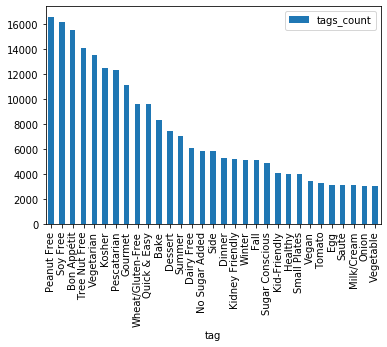

In [16]:
tags_count[tags_count['tags_count'] >= 3000].plot(kind='bar',y='tags_count',x='tag')
plt.savefig('plots/tags_freq.png',bbox_inches='tight')
plt.show()

In [41]:
sample_df[allergy].apply(pd.value_counts)

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
0,10687,10906,12220,14718,16845,19635
1,9313,9094,7780,5282,3155,365


### Correlation Between Top 25 tags

Below picks top 25 tags and removes 'Gourmet' and 'Bon Appetite' tags. We then loop through tags_corr list and then loop through df. In the loop, we find if tags_crr[i], is in tags list. If it is, then we append 1 or 0 otherwise. We then create new column in sample_df with tags_corr[i] and assign those values to that column.

Once those columns are added, we then use tags_corr to take out columns with top 25 tags and then find correlation. 

We are happy with result we got. It show good correlation between tags as we expected.

In [17]:
tags_corr = tags_count.head(25).values
tags_corr
tags_corr = [i[1] for i in tags_corr if(i[1] !='Gourmet' and "Bon App" not in i[1])]
# tags_corr

In [18]:

for i in tags_corr:
    tags_value=[]
    for tags in sample_df['tags']:
        if(i in tags):
            tags_value.append(1)
        else:
            tags_value.append(0)
    sample_df[i] = tags_value

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
tags_c = sample_df[tags_corr]
top_25_tags = sample_df[tags_corr].corr()

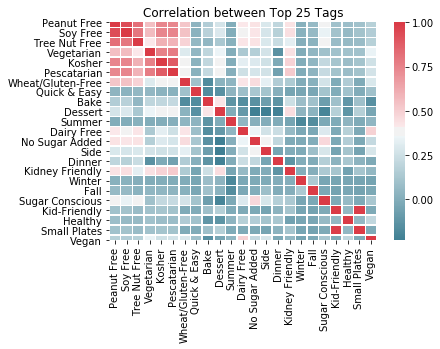

In [20]:
sns.heatmap(top_25_tags,xticklabels=tags_c.columns,yticklabels=tags_c.columns,linewidth=.5,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation between Top 25 Tags")
plt.savefig("plots/toptagscorr.png", bbox_inches='tight')
plt.show()

### Correlations Between Top 25 Ingredients

We perform same thing we did for top 25 tags below and find correlation.

In [21]:
ingredients_corr = ['salt', 'sugar', 'garlic', 'egg', 'unsalted butter', 'onion', 'olive oil', 'water', 
                    'all purpose flour', 'black pepper', 
                    'lemon juice', 'extra virgin olive oil', 'vegetable oil', 'kosher salt', 'parsley', 
                    'butter', 'vanilla extract', 'milk', 'tomato', 'ginger', 'thyme', 'cinnamon', 'shallot', 
                    'heavy cream', 'baking powder']
# ingredients_corr

In [22]:
top_ingredient_df = sample_df[ingredients_corr]

In [23]:
top_ingredient_df.shape

(20000, 25)

In [24]:
top_ingredient_df = top_ingredient_df[(top_ingredient_df.T != 0).any()] #drops zeros column

In [25]:
top_ingredient_df.shape

(18481, 25)

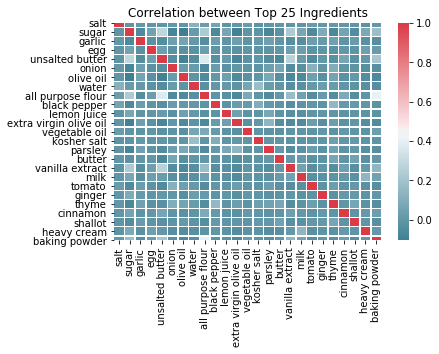

In [26]:
sns.heatmap(top_ingredient_df.corr(),xticklabels=top_ingredient_df.columns,yticklabels=top_ingredient_df.columns,linewidth=.5,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation between Top 25 Ingredients")
plt.savefig("plots/topingredientscorr.png", bbox_inches='tight')
plt.show()

### Top Tags for Each Yearly Season

We were watching a youtube video which reorder top 10 TV series from 1986 to 2019 based on views. It was interesting to see how TV shows types changes through time. Like what they were doing, we wanted to see most common or top tags what was used through different yearly season.

https://youtu.be/7DemM7UGmIg

In [27]:
addSeasontypesToDF(sample_df,['Spring','Summer','Fall','Winter'],'season').head(2)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Aleppo chili,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amaro Montenegro,Amontillado sherry,Anaheim chili,Anaheim pepper,Ancho Chili Sauce,...,Dinner,Kidney Friendly,Winter,Fall,Sugar Conscious,Kid-Friendly,Healthy,Small Plates,Vegan,season
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,4
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,3


In [28]:
spring = []
summer = []
fall = []
winter =[]
spring_df = sample_df.tags[sample_df['season']==1].values
summer_df = sample_df.tags[sample_df['season']==2].values
fall_df = sample_df.tags[sample_df['season']==3].values
winter_df = sample_df.tags[sample_df['season']==4].values
non_season_df = sample_df.tags[sample_df['season'] == 0].values

The results were great. We saw what we wanted to see. In spring, lemon is the lead which explains a lot. It is around season when many get colds and allergy. So people uses vitamin C to stay healthy. For summer, BBQ and Grills are in the lead. It makes sense. There is no school and summer time is mostly dedicated to family and friends time, we see those food choice. It was also interesting to see food choice besides those two leading choice. We see many cold food for summer. It explains, because it's hot and to stay cool people will choose cold food during summer than winter. In fall and winter, we see many holiday theme food. 

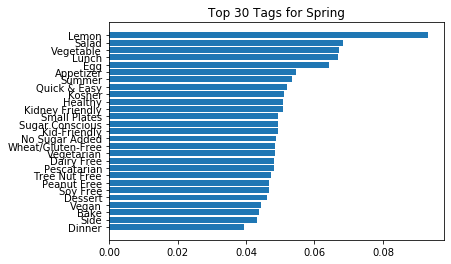

In [29]:
s = Counter()
for i in range(len(spring_df)):
#     print(spring_df[i])
    s.update(spring_df[i])
# for i in s.most_common(30):
#     if(i[0] != 'Spring' and i[0] !='Gourmet' and "Bon App" not in i[0]):
#         total = tags_count.tags_count[tags_count['tag'] == i[0]].values[0]
        
# print(s.most_common(10))
s = [(i[0],i[1]/tags_count.tags_count[tags_count['tag'] == i[0]].values[0]) for i in s.most_common(30) if(i[0] != 'Spring' and i[0] !='Gourmet' and "Bon App" not in i[0])]
# print('\n\n',s)
s = sorted(s, key = lambda x: x[1]) 
# print('\n\n',s)
keys = [x[0] for x in s]
values = [x[1] for x in s]
plt.barh(keys,values)
plt.title("Top 30 Tags for Spring")
plt.savefig('plots/springtag.png', bbox_inches='tight')
plt.show()

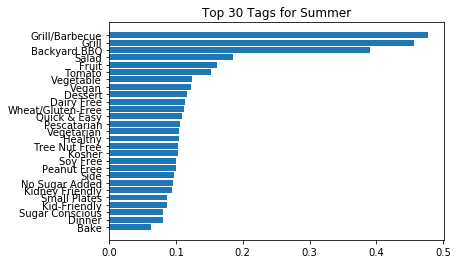

In [30]:
su = Counter()
for i in range(len(summer_df)):
    su.update(summer_df[i])
su = [(i[0],i[1]/tags_count.tags_count[tags_count['tag'] == i[0]].values[0]) for i in su.most_common(30) if(i[0] != 'Summer' and i[0] !='Gourmet' and "Bon App" not in i[0])]
su = sorted(su, key = lambda x: x[1]) 
keys = [x[0] for x in su]
values = [x[1] for x in su]
plt.barh(keys,values)
plt.title("Top 30 Tags for Summer")
plt.savefig('plots/summertag.png', bbox_inches='tight')
plt.show()

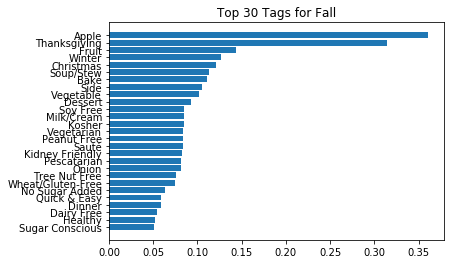

In [31]:
f = Counter()
for i in range(len(fall_df)):
    f.update(fall_df[i])
f = [(i[0],i[1]/tags_count.tags_count[tags_count['tag'] == i[0]].values[0]) for i in f.most_common(30) if(i[0] != 'Fall' and i[0] !='Gourmet' and "Bon App" not in i[0])]
f = sorted(f, key = lambda x: x[1]) 
keys = [x[0] for x in f]
values = [x[1] for x in f]
plt.barh(keys,values)
plt.title("Top 30 Tags for Fall")
plt.savefig('plots/falltag.png', bbox_inches='tight')
plt.show()

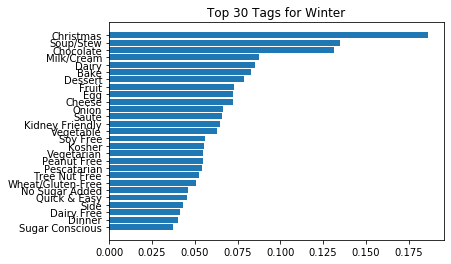

In [32]:
w = Counter()
for i in range(len(winter_df)):
    w.update(winter_df[i])
w = [(i[0],i[1]/tags_count.tags_count[tags_count['tag'] == i[0]].values[0]) for i in w.most_common(30) if(i[0] != 'Winter' and i[0] !='Gourmet' and "Bon App" not in i[0])]
w = sorted(w,key= lambda x:x[1])
keys = [x[0] for x in w]
values = [x[1] for x in w]
plt.barh(keys,values)
plt.title("Top 30 Tags for Winter")
plt.savefig('plots/wintertag.png', bbox_inches='tight')
plt.show()

### Allergy Awareness

For my own curiosity, I wanted to see how Allergy correlations with cuisine from USA and Non-USA cuisine. I had no knowledge of what allergy was until I came to USA. So I wanted to see how many allergy labels are in USA cuisine and Non-USA cuisines. To do that, I manually look through each tags value and took out label with country names or USA city name. Then I took USA state list from a website and combined USA cities and states list together. I used that list and label recipe that contains USA cities or state as True for 'usa_cuisine' column. As for Non-USA cuisine, that list contains city or country that is not in USA and label them as False for 'usa_cuisine' column. Then remaining recipe, I labeled them as 'NA'. I expected USA cuisine to contain more allergy tags than Non-USA cuisine. The plot also says the same thing. Even though, it was not a novel discovery, It was interesting to see.  

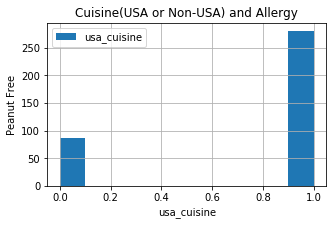

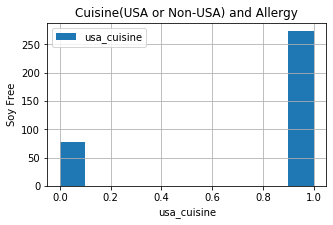

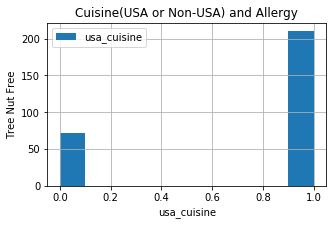

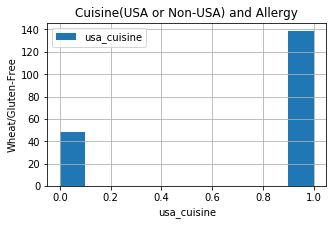

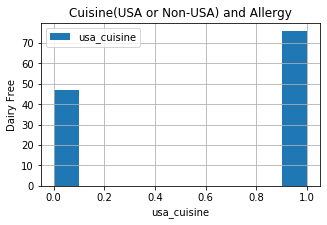

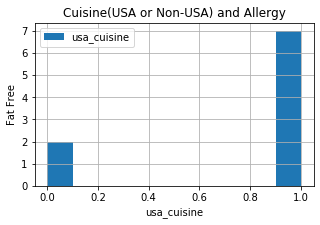

In [33]:
copy = cuisine_df[(cuisine_df['usa_cuisine'] != 2)]
copy = dropColumn(copy,['avg_rating','best_rating','prepare_again_rating','num_reviews','tags','title'])
allergy = ['Peanut Free','Soy Free','Tree Nut Free','Wheat/Gluten-Free','Dairy Free','Fat Free']
for i in allergy:
    allergy_df = copy[(copy[i] == 1)]
    allergy_df = allergy_df[['usa_cuisine',i]]
    allergy_df.plot.hist(x=i,y='usa_cuisine',figsize=(5,3),grid=True)
    plt.title('Cuisine(USA or Non-USA) and Allergy')
    plt.xlabel('usa_cuisine')
    plt.ylabel(i)
    


### Plot Correlation for Allergy Features

In [34]:
# converts True/False column values to 1/0 if needed.
sample_df[allergy] *= 1
sample_df.head(1)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Aleppo chili,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amaro Montenegro,Amontillado sherry,Anaheim chili,Anaheim pepper,Ancho Chili Sauce,...,Dinner,Kidney Friendly,Winter,Fall,Sugar Conscious,Kid-Friendly,Healthy,Small Plates,Vegan,season
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,4


In [35]:
allergy_corr_df = sample_df[allergy]

In [36]:
print("Correlation Table for Allergy Tags")
allergy_corr_df.corr()

Correlation Table for Allergy Tags


,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
Peanut Free,1.000000,0.940356,0.818149,0.530327,0.414655,0.138566
Soy Free,0.940356,1.000000,0.795322,0.544888,0.365398,0.138807
Tree Nut Free,0.818149,0.795322,1.000000,0.490006,0.428717,0.155550
Wheat/Gluten-Free,0.530327,0.544888,0.490006,1.000000,0.428693,0.194546
Dairy Free,0.414655,0.365398,0.428717,0.428693,1.000000,0.285322
Fat Free,0.138566,0.138807,0.155550,0.194546,0.285322,1.000000


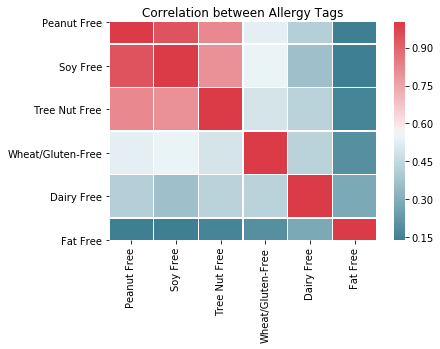

In [37]:
sns.heatmap(allergy_corr_df.corr(),xticklabels=allergy_corr_df.columns,yticklabels=allergy_corr_df.columns,linewidth=.5,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation between Allergy Tags")
plt.savefig("allergycorr.png")
plt.show()

In [38]:
reviews = ['avg_rating','best_rating','prepare_again_rating','num_reviews']
review_df = sample_df[reviews].dropna()
review_df = review_df[review_df.columns].astype(float)


In [39]:
review_df.corr()

,avg_rating,best_rating,prepare_again_rating,num_reviews
avg_rating,1.000000,0.073654,0.824393,0.218885
best_rating,0.073654,1.000000,0.065569,0.014233
prepare_again_rating,0.824393,0.065569,1.000000,0.211160
num_reviews,0.218885,0.014233,0.211160,1.000000


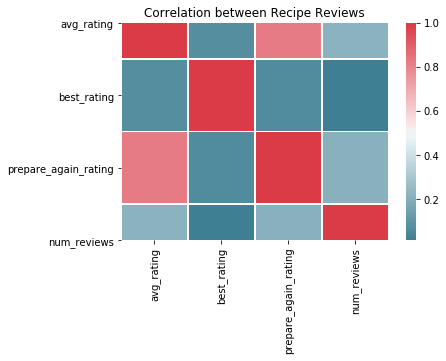

In [40]:
sns.heatmap(review_df.corr(),xticklabels=review_df.columns,yticklabels=review_df.columns,linewidth=.5,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation between Recipe Reviews")
plt.savefig("reiviewcorr.png")
plt.show()